# PCA is widely used in unsupervised learning. In this jupyter notebook, we're going to explore how to apply this method to genetic analysis.

In [1]:
# Import parts of Biopython
from Bio import SeqIO
import pandas as pd

In [2]:
# File path to FA file
path_to_file = 'the path ccrescentus.fa is in'
 
# Open file with "with" statement to avoid problems with access to original file (in case computer hangs or there will be any other problem)
with open(path_to_file, mode='r') as handle:

    # Use Biopython's parse function to process individual
    # FASTA records (thus reducing memory footprint)
    for record in SeqIO.parse(handle, 'fasta'):

        # Extract individual parts of the FASTA record
        identifier = record.id
        description = record.description
        sequence = record.seq

        # Example: adapt to extract features you are interested in
        print('----------------------------------------------------------')
        print('Processing the record {}:'.format(identifier))
        print('Its description is: \n{}'.format(description))
        amount_of_nucleotides = len(sequence)
        print('Its sequence contains {} nucleotides.'.format(amount_of_nucleotides))

----------------------------------------------------------
Processing the record fragment:
Its description is: 
fragment of c.crescentus genome
Its sequence contains 305400 nucleotides.


We've got 305400 nucleotides in terms of A, C, G, T. To investigete which length of combination fits genetic analysis well, we can firstly divide the entire sequence into fragments with the same lenth, then create a table with all the combos as columns and fragment numbers as rows. The value is equal to counts of each combination in each fragment.  

In [3]:
def CalFre(seq, len_of_words=4, len_of_fragment= 300):
    """
    seq is a gene sequence represented by A,C,T,G
    len_of_words is the length of the words in the sequence to be counted
    len_of_fragment is the length of the frament is the sequence, the longer the sequence, the longer the fragment
    """
    
    import itertools
    key=[''.join(x) for x in itertools.product('acgt', repeat=len_of_words)]
    step = len_of_fragment
    parts = []
    for i in range(int(len(sequence)/step)): 
        sub = sequence[i * step: (i + 1) * step]
        parts.append(sub)
    if len(sequence)%step != 0:
        parts.append(sequence[(i + 1)* step: ])
    
    data = {}
    for word in key:
        data[word]=[]
        
    for word in key:
        for sub in parts:    
            count=0
            for i in range(int(len(sub)/len_of_words)):
            
                if word in sub[i*len_of_words:(i+1)*len_of_words]  :
                    count+=1
            data[word].append(count)
                     
    return pd.DataFrame.from_dict(data)
    

Now we can generate our tables with length from 1 to 4, and use PCA method to decomposed data into 2-dimenal scale, then plot it.

In [4]:
dt1=CalFre(sequence,1,300)
dt2=CalFre(sequence,2,300)
dt3=CalFre(sequence,3,300)
dt4=CalFre(sequence,4,300)

In [5]:
def pcaplot(dt):
    """
    dt is a dataframe derived from gene fragmented
    """
    mean=dt.values.mean()
    std=dt.values.std()
    dt=(dt-mean)/std

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(dt)
    import matplotlib.pyplot as plt
    import matplotlib.pyplot as plt
    %matplotlib inline

    fig,ax=plt.subplots(figsize=(10,10))
    return plt.scatter(principalComponents[:,0], principalComponents[:,1])

Unlike dt1,dt2 and dt4, dt3 gives us a clear plot with 7 clusters.

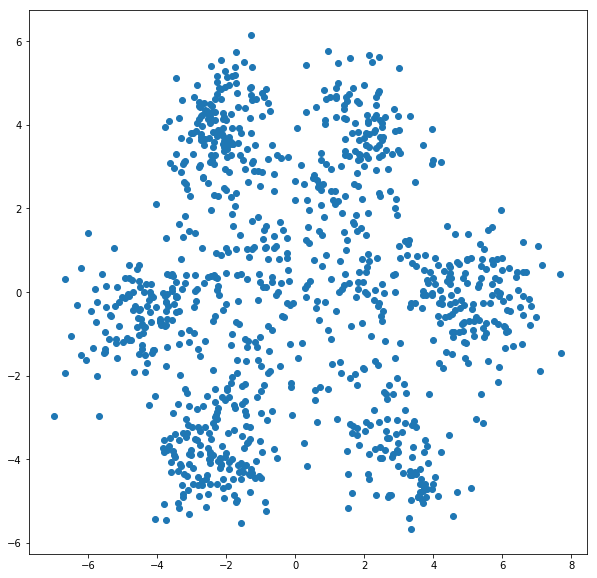

In [6]:
pcaplot(dt3)

Finally, let's use kmean algo to mark each cluster and plot it.

In [7]:
def pcacom(dt):
    """
    dt is a dataframe derived from gene fragmented
    """
    mean=dt.values.mean()
    std=dt.values.std()
    dt=(dt-mean)/std

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    return pca.fit_transform(dt)

In [8]:
principalComponents = pcacom(dt3)
principalComponents

array([[ 1.78809142, -2.21802836],
       [ 2.13636744, -3.8750528 ],
       [ 3.5990545 , -4.23291298],
       ...,
       [ 1.91766253, -0.74025994],
       [-1.31817051,  4.16914427],
       [-2.31563741,  4.60687292]])

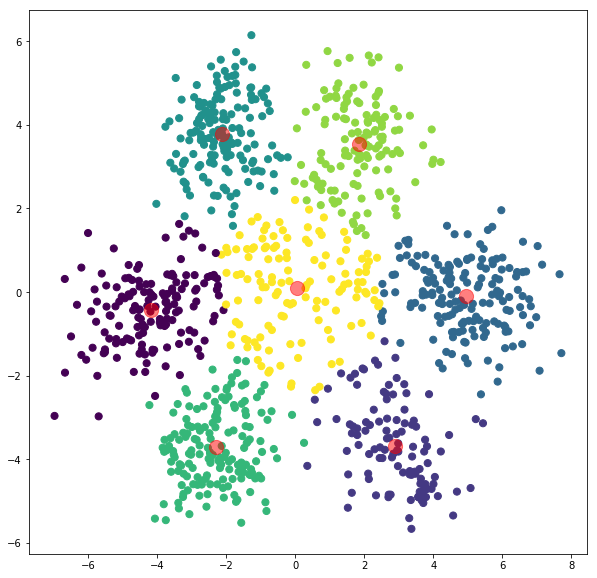

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,10))
kmeans = KMeans(n_clusters=7)
kmeans.fit(principalComponents)
y_kmeans = kmeans.predict(principalComponents)
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

In [10]:
dt3['clustre_num']=y_kmeans

In [11]:
dt3.tail(10)

,aaa,aac,aag,aat,aca,acc,acg,act,aga,agc,...,tct,tga,tgc,tgg,tgt,tta,ttc,ttg,ttt,clustre_num
1008,1,1,0,0,1,1,1,0,1,5,...,5,4,1,2,0,0,0,0,0,0
1009,0,0,6,0,0,0,8,0,0,2,...,1,0,3,1,0,0,1,7,1,5
1010,0,2,0,0,2,3,1,0,1,5,...,2,0,2,2,0,0,1,8,0,5
1011,0,1,2,0,0,1,5,0,1,3,...,0,0,0,3,0,0,1,7,1,5
1012,0,3,2,0,2,0,3,1,0,0,...,0,1,0,5,0,0,2,9,0,5
1013,1,0,2,1,1,2,1,0,1,4,...,1,1,1,2,1,0,1,7,0,5
1014,0,0,1,0,0,2,3,0,1,1,...,0,0,0,0,0,0,3,8,0,2
1015,0,0,2,0,1,1,1,0,1,1,...,1,1,2,2,0,0,2,2,2,6
1016,2,2,1,0,5,2,2,2,3,1,...,0,5,7,3,1,0,1,0,1,3
1017,0,1,1,0,1,3,2,0,4,1,...,2,6,5,1,1,0,0,0,0,3
